Import the necessary libraries.

In [1]:
import csv
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sentence_transformers import SentenceTransformer
from create_input_lists import create_input_lists_from_csv, lemmatize
from statistics import mean
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from statistics import mean, median, mode
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict, Counter

Obtain and pre-process the texts.

In [2]:
paragraph_path = './OneDrive-2020-12-04/gen_chem/paragraphs.csv'
assessment_path = './OneDrive-2020-12-04/gen_chem/assessments.csv'

In [3]:
para_ids, lemm_para, orig_para, assess_ids, lemma_assess, orig_assess = create_input_lists_from_csv(paragraph_path, assessment_path)

Obtain the BERT embeddings of the texts.

In [4]:
def get_embeddings_sentBert(texts):
    model = SentenceTransformer('paraphrase-distilroberta-base-v2')
    text_embeddings = model.encode(texts)

    return np.array(text_embeddings)

para_vectors = get_embeddings_sentBert(lemm_para)
assess_vectors = get_embeddings_sentBert(lemma_assess)

In [5]:
print(para_vectors.shape)
print(assess_vectors.shape)

(2860, 768)
(1275, 768)


In [6]:
para_nonzero_counts = []
for vector in para_vectors:
    para_nonzero_counts.append(np.count_nonzero(vector))

assess_nonzero_counts = []
for vector in assess_vectors:
    assess_nonzero_counts.append(np.count_nonzero(vector))

Output Summary Statistics of Vectorizations:

In [7]:
print('TF-IDF for Paragraphs:\n')
print('Average Number of Non-Zeros:', mean(para_nonzero_counts))
print('Total # of Dimensions:', para_vectors.shape[1])


print('\n\nTF-IDF for Assessments:\n')
print('Average Number of Non-Zeros:', mean(assess_nonzero_counts))
print('Total # of Dimensions:', assess_vectors.shape[1])

TF-IDF for Paragraphs:

Average Number of Non-Zeros: 768
Total # of Dimensions: 768


TF-IDF for Assessments:

Average Number of Non-Zeros: 768
Total # of Dimensions: 768


In [8]:
def plot_distances(distances_list):
    plt.hist(distances_list, rwidth = 0.8, bins=np.arange(min(distances_list), max(distances_list) + 0.01, 0.01))
    plt.xlabel('Pairwise Distance',fontsize=10)
    plt.ylabel('Frequency',fontsize=10)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.xticks(np.arange(min(distances_list), max(distances_list)+0.1, 0.1))
    plt.grid()
    plt.show()
    
def plot_similarities(cos_sim_list):
    plt.hist(cos_sim_list, rwidth = 0.8, bins=np.arange(min(cos_sim_list), max(cos_sim_list) + 0.01, 0.01))
    plt.xlabel('Pairwise Cosine Similarity',fontsize=10)
    plt.ylabel('Frequency',fontsize=10)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.xticks(np.arange(min(cos_sim_list), max(cos_sim_list)+0.1, 0.1))
    plt.grid()
    plt.show()
    
def calculate_pairwise_metrics(pairs):    
    cos_sim_list = []
    dist_list = []
    orthogonal_count = 0
    for pair in pairs:
        a,b = pair
        a = np.array(a)
        b = np.array(b)
        cos_sim = dot(a, b)/(norm(a)*norm(b))
        cos_sim_list.append(cos_sim)

        if -0.01 <= cos_sim <= 0.01:
            orthogonal_count += 1

        dist = norm(a - b)
        dist_list.append(dist)
    
    return(cos_sim_list, orthogonal_count, dist_list)

def print_similarity_statistics(sim_list):
    print('Cosine Similarity Mean:', mean(sim_list))
    print('Cosine Similarity Median:', median(sim_list))
    print('Cosine Similarity Mode:', mode(sim_list))
    print('Cosine Similarity Min:', min(sim_list))
    print('Cosine Similarity Max:', max(sim_list))
    
def print_distance_statistics(dist_list):
    print('Euclidean Distance Mean:', mean(dist_list))
    print('Euclidean Distance Median:', median(dist_list))
    print('Euclidean Distance Mode:', mode(dist_list))
    print('Euclidean Distance Min:', min(dist_list))
    print('Euclidean Distance Max:', max(dist_list))

Cosine Similarity Mean: 0.15751713618455074
Cosine Similarity Median: 0.13302906523433158
Cosine Similarity Mode: 1.0
Cosine Similarity Min: -0.23466059791378716
Cosine Similarity Max: 1.0000000000000002

Number of Pairs: 4088370
Number of Orthogonal Pairs: 164123


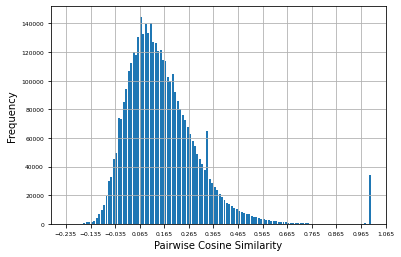

Euclidean Distance Mean: 19.678437552427123
Euclidean Distance Median: 19.99947204007117
Euclidean Distance Mode: 0.0
Euclidean Distance Min: 0.0
Euclidean Distance Max: 28.07460822204368


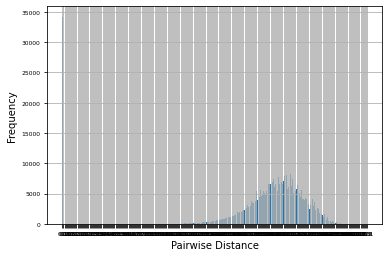

In [9]:
para_vectors = para_vectors.tolist()

para_pairs = [[a, b] for idx, a in enumerate(para_vectors) for b in para_vectors[idx + 1:]]

para_sim_list, para_count, para_dist_list = calculate_pairwise_metrics(para_pairs)
print_similarity_statistics(para_sim_list)
print('\nNumber of Pairs:', len(para_pairs))
print('Number of Orthogonal Pairs:', para_count)
plot_similarities(para_sim_list)

print_distance_statistics(para_dist_list)
plot_distances(para_dist_list)

Cosine Similarity Mean: 0.24360421669690777
Cosine Similarity Median: 0.21970276935817606
Cosine Similarity Mode: 1.0
Cosine Similarity Min: -0.22610760045978706
Cosine Similarity Max: 1.0000000000000002

Number of Pairs: 812175
Number of Orthogonal Pairs: 8352
Percentage of Orthogonal Pairs: 0.010283498014590452


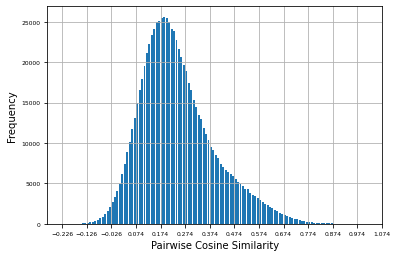

Euclidean Distance Mean: 17.441214154634807
Euclidean Distance Median: 17.739115978969103
Euclidean Distance Mode: 0.0
Euclidean Distance Min: 0.0
Euclidean Distance Max: 27.29860854193884


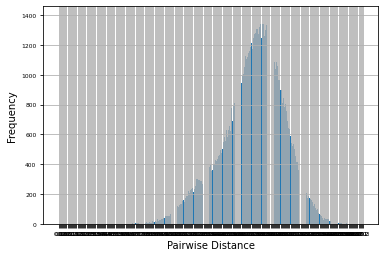

In [10]:
assess_vectors = assess_vectors.tolist()

assess_pairs = [[a, b] for idx, a in enumerate(assess_vectors) for b in assess_vectors[idx + 1:]]

assess_sim_list, assess_count, assess_dist_list = calculate_pairwise_metrics(assess_pairs)
print_similarity_statistics(assess_sim_list)
print('\nNumber of Pairs:', len(assess_pairs))
print('Number of Orthogonal Pairs:', assess_count)
print('Percentage of Orthogonal Pairs:', assess_count/len(assess_pairs))
plot_similarities(assess_sim_list)

print_distance_statistics(assess_dist_list)
plot_distances(assess_dist_list)

In [35]:
km = KMeans(n_clusters = 200, max_iter = 50000, init = 'k-means++')
cluster_assignment = km.fit(assess_vectors).labels_
s = silhouette_score(assess_vectors, cluster_assignment, metric='euclidean')
print(s)

0.08857169548049601


In [36]:
clusterIndex_to_clusteredText1 = defaultdict(lambda: " ")
text_id1_to_clusterIndex = dict()

for i, clusterIndex in enumerate(cluster_assignment): # len(cluster_assignment) is equal to len(vectors)
    clusterIndex_to_clusteredText1[clusterIndex] += orig_assess[i] + ". " 
    text_id1_to_clusterIndex[assess_ids[i]] = clusterIndex

Cosine Similarity Mean: 0.24042243140867528
Cosine Similarity Median: 0.21827091644270158
Cosine Similarity Mode: 0.21510773420863666
Cosine Similarity Min: -0.22610760045978706
Cosine Similarity Max: 0.9377070546374202

Number of Pairs: 805112
Number of Orthogonal Pairs: 8352
Percentage of Orthogonal Pairs: 0.010373711980444957


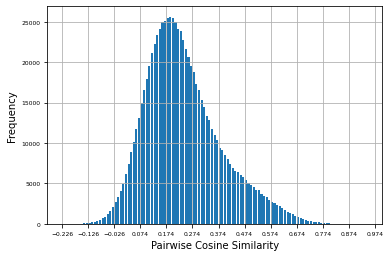

Euclidean Distance Mean: 17.492202812913202
Euclidean Distance Median: 17.76533807589591
Euclidean Distance Mode: 21.12959055199726
Euclidean Distance Min: 4.461529153859777
Euclidean Distance Max: 27.29860854193884


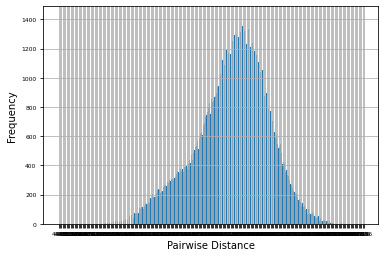

In [37]:
assess_pair_ids = [[a, b] for idx, a in enumerate(assess_ids) for b in assess_ids[idx + 1:]]

inter_cluster_pairs = []
for index in range(0,len(assess_pairs)):
    a, b = assess_pairs[index]
    a_id, b_id = assess_pair_ids[index]
    a_cluster = text_id1_to_clusterIndex[a_id]
    b_cluster = text_id1_to_clusterIndex[b_id]
    if a_cluster != b_cluster:
        inter_cluster_pairs.append([a,b])
    
cluster_sim_list, cluster_count, cluster_dist_list = calculate_pairwise_metrics(inter_cluster_pairs)
print_similarity_statistics(cluster_sim_list)
print('\nNumber of Pairs:', len(inter_cluster_pairs))
print('Number of Orthogonal Pairs:', cluster_count)
print('Percentage of Orthogonal Pairs:', cluster_count/len(inter_cluster_pairs))
plot_similarities(cluster_sim_list)

print_distance_statistics(cluster_dist_list)
plot_distances(cluster_dist_list)

Cosine Similarity Mean: 0.6062962055089454
Cosine Similarity Median: 0.6216462139505987
Cosine Similarity Mode: 1.0
Cosine Similarity Min: 0.0768479055258297
Cosine Similarity Max: 1.0000000000000002

Number of Pairs: 7063
Number of Orthogonal Pairs: 0
Percentage of Orthogonal Pairs: 0.0


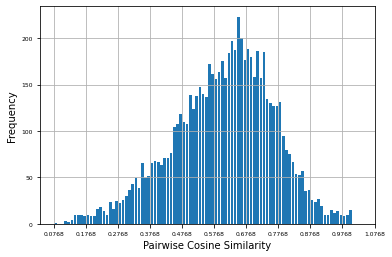

Euclidean Distance Mean: 11.629012449433825
Euclidean Distance Median: 11.50989721262632
Euclidean Distance Mode: 0.0
Euclidean Distance Min: 0.0
Euclidean Distance Max: 22.91548908506628


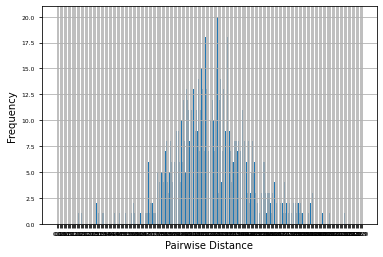

In [38]:
intra_cluster_pairs = []
for index in range(0,len(assess_pairs)):
    a, b = assess_pairs[index]
    a_id, b_id = assess_pair_ids[index]
    a_cluster = text_id1_to_clusterIndex[a_id]
    b_cluster = text_id1_to_clusterIndex[b_id]
    if a_cluster == b_cluster:
        intra_cluster_pairs.append([a,b])
    
cluster_sim_list, cluster_count, cluster_dist_list = calculate_pairwise_metrics(intra_cluster_pairs)
print_similarity_statistics(cluster_sim_list)
print('\nNumber of Pairs:', len(intra_cluster_pairs))
print('Number of Orthogonal Pairs:', cluster_count)
print('Percentage of Orthogonal Pairs:', cluster_count/len(intra_cluster_pairs))
plot_similarities(cluster_sim_list)

print_distance_statistics(cluster_dist_list)
plot_distances(cluster_dist_list)

In [39]:
Counter(cluster_assignment)

Counter({78: 3,
         176: 1,
         156: 1,
         69: 38,
         25: 6,
         115: 5,
         1: 7,
         3: 9,
         191: 12,
         91: 2,
         89: 2,
         98: 11,
         165: 3,
         133: 2,
         175: 1,
         72: 23,
         152: 1,
         149: 1,
         164: 1,
         182: 5,
         110: 5,
         95: 2,
         127: 25,
         107: 5,
         46: 5,
         28: 8,
         40: 4,
         184: 3,
         54: 7,
         118: 3,
         5: 10,
         199: 2,
         67: 1,
         96: 32,
         13: 17,
         80: 5,
         194: 1,
         60: 15,
         158: 1,
         37: 23,
         170: 3,
         159: 5,
         70: 27,
         147: 11,
         10: 7,
         77: 10,
         141: 10,
         186: 15,
         86: 10,
         34: 6,
         123: 8,
         195: 6,
         23: 5,
         14: 17,
         82: 5,
         160: 4,
         102: 6,
         0: 1,
         56: 2,
         59: 7,

In [17]:
k = 2
k_list = []
best_k = 75

score_list = []
best_score = -2.0

while k <= 500:
    km = KMeans(n_clusters = k, max_iter = 50000, init = 'k-means++', random_state=43)
    cluster_assignment = km.fit(assess_vectors).labels_
    s = silhouette_score(assess_vectors, cluster_assignment, metric='euclidean')
    if s > best_score:
        best_score = s
        best_k = k
    k_list.append(k)
    score_list.append(s)
    k += 1

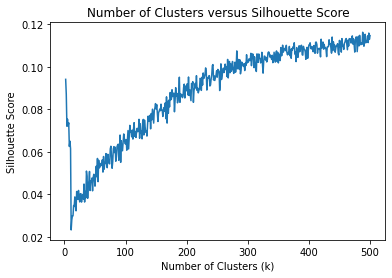

In [18]:
plt.plot(k_list,score_list)
plt.title('Number of Clusters versus Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [19]:
print('Best value for k:', best_k)
print('Best Silhouette Score:', best_score)

Best value for k: 488
Best Silhouette Score: 0.1163041471454313


In [41]:
runs = 0
assignment_list = []
while runs < 10:
    km = KMeans(n_clusters = 200, max_iter = 50000, init = 'k-means++')
    cluster_assignment = km.fit(assess_vectors).labels_
    runs  += 1
    assignment_list.append(cluster_assignment)

clustering_pairs = [[a, b] for idx, a in enumerate(assignment_list) for b in assignment_list[idx + 1:]]

pair_numbers = []
for number in range(0,10):
    for another_number in range(0,10):
        if another_number > number: 
            pair_numbers.append([number+1, another_number+1])

from sklearn.metrics.cluster import adjusted_mutual_info_score

ami_score_list = []
for index in range(0, len(clustering_pairs)):
    label = 'Comparing Run ' + str(pair_numbers[index][0]) + ' and Run ' + str(pair_numbers[index][1])
    ami_score = adjusted_mutual_info_score(clustering_pairs[index][0], clustering_pairs[index][1])
    ami_score_list.append([label, ami_score])
    
import csv

with open("../../../OneDrive/SMART/Jesse_2021/StoryBoards/SMART_cluster_assignment_OLI General Chemistry I_sentence-BERT.csv","w+") as my_csv:
    newarray = csv.writer(my_csv,delimiter=',')
    newarray.writerows(assignment_list)
    newarray.writerows(ami_score_list)